In [20]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reframed

In [7]:
#open summary
models = pd.read_table("./data/embl_gems/model_list.tsv")
models

,assembly_accession,taxid,organism_name,infraspecific_name,file_path
0,GCF_000010525.1,438753,Azorhizobium caulinodans ORS 571,strain=ORS 571,models/a/azorhizobium/Azorhizobium_caulinodans...
1,GCF_000007365.1,198804,Buchnera aphidicola str. Sg (Schizaphis graminum),strain=Sg,models/b/buchnera/Buchnera_aphidicola_str_Sg_S...
2,GCF_000007725.1,224915,Buchnera aphidicola str. Bp (Baizongia pistaciae),strain=Bp (Baizongia pistaciae),models/b/buchnera/Buchnera_aphidicola_str_Bp_B...
3,GCF_000009605.1,107806,Buchnera aphidicola str. APS (Acyrthosiphon pi...,strain=APS,models/b/buchnera/Buchnera_aphidicola_str_APS_...
4,GCF_000090965.1,372461,Buchnera aphidicola BCc,strain=BCc,models/b/buchnera/Buchnera_aphidicola_BCc.xml.gz
...,...,...,...,...,...
5583,GCF_002220865.1,1977292,Bacillus xerothermodurans,strain=ATCC 27380,models/b/bacillus/Bacillus_xerothermodurans_AT...
5584,GCF_002110465.1,1981054,unicellular cyanobacterium SU2,strain=SU2,models/u/unicellular/unicellular_cyanobacteriu...
5585,GCF_002172675.1,1982589,unicellular cyanobacterium SU3,strain=SU3,models/u/unicellular/unicellular_cyanobacteriu...
5586,GCF_900184705.1,1986204,Brevefilum fermentans,NaN,models/b/brevefilum/Brevefilum_fermentans.xml.gz


In [8]:
from reframed import ReactionType

def get_u(model, sol):
    u = {m:0 for m in model.get_external_metabolites()}
    
    #loop over external metabolites 
    for m in model.get_external_metabolites():
        #and all associated reactions
        for (k,v) in model.metabolite_reaction_lookup()[m].items(): 
            if model.reactions[k].reaction_type == ReactionType.TRANSPORT:
                s = model.reactions[k].get_substrates()
                p = model.reactions[k].get_products()
    
                flux = sol.values[k]
                
                #if m is substrate and reaction goes forward
                if m in s:
                    if flux > 0:
                        u[m] = u[m] - sol.values[k] * v
                
                #if m is product and reaction is in reverse
                if m in p:
                    if flux < 0:
                        u[m] = u[m] - sol.values[k] * v
    return(u)

def get_l(model, sol):
    l = {m:0 for m in model.get_external_metabolites()}
    
    #loop over external metabolites 
    for m in model.get_external_metabolites():
        #and all associated reactions
        for (k,v) in model.metabolite_reaction_lookup()[m].items(): 
            if model.reactions[k].reaction_type == ReactionType.TRANSPORT:
                s = model.reactions[k].get_substrates()
                p = model.reactions[k].get_products()
    
                flux = sol.values[k]
                
                #if m is product and reaction goes forward
                if m in p:
                    if flux > 0:
                        l[m] = l[m] - sol.values[k] * v
                
                #if m is substrate and reaction is in reverse
                if m in s:
                    if flux < 0:
                        l[m] = l[m] - sol.values[k] * v
    return(l)

In [10]:
def get_structure(model):

    u = {m_:0 for m_ in model.get_external_metabolites()}
    l = {m_:0 for m_ in model.get_external_metabolites()}
    
    for m_ in model.get_external_metabolites():
        u[m_] = 0.0
        l[m_] = 0.0
        for (k,v) in model.metabolite_reaction_lookup()[m_].items():
            if model.reactions[k].reaction_type != ReactionType.EXCHANGE:
                    s = model.reactions[k].get_substrates()
                    p = model.reactions[k].get_products()

                    if v < 0:
                        u[m_] += abs(v)
                    else:   
                        l[m_] += abs(v)
                        
    return(u,l)

def get_reactions(model, sol):

    u = {m_:0 for m_ in model.get_external_metabolites()}
    l = {m_:0 for m_ in model.get_external_metabolites()}
    
    for m_ in model.get_external_metabolites():
        u[m_] = 0.0
        l[m_] = 0.0
        for (k,v) in model.metabolite_reaction_lookup()[m_].items():
            if model.reactions[k].reaction_type != ReactionType.EXCHANGE:
                    s = model.reactions[k].get_substrates()
                    p = model.reactions[k].get_products()
    
                    flux = sol.values[k]
                    if flux != 0:
                        if v < 0:
                            if flux > 0:
                                u[m_] += flux * abs(v)
                            else:
                                l[m_] -= flux * abs(v) 
                        else:
                            if flux > 0:
                                l[m_] += flux * abs(v)
                            else:                    
                                u[m_] -= flux * abs(v)
    return(u,l)

In [11]:
u_dict = {}
l_dict = {}

for (i,s) in models.iterrows():
    print(i, end='\r')
    fp = "./data/embl_gems/" + s.file_path
    m = reframed.load_cbmodel(fp)

    # env = reframed.Environment.complete(m)
    # sol = reframed.FBA(m, constraints=env)

    r = get_structure(m)

    u_dict[s.assembly_accession] = r[0]
    l_dict[s.assembly_accession] = r[1]    

In [41]:
metabolites = set.union(*[set(u_dict[i].keys()) for i in u_dict.keys()])
consumers = models.assembly_accession

#make lookups
ml = {v:i for (i,v) in enumerate(metabolites)}
cl = {v:i for (i,v) in enumerate(consumers)}

C = np.zeros((len(consumers), len(metabolites)))
D = np.zeros((len(consumers), len(metabolites)))

for i in consumers:
    for j in u_dict[i]:
        C[cl[i],ml[j]] = u_dict[i][j]
    
    for j in l_dict[i]:
        D[cl[i],ml[j]] = l_dict[i][j]

np.savetxt("./data/C_mat.csv", C, delimiter = ",")
np.savetxt("./data/D_mat.csv", D, delimiter = ",")

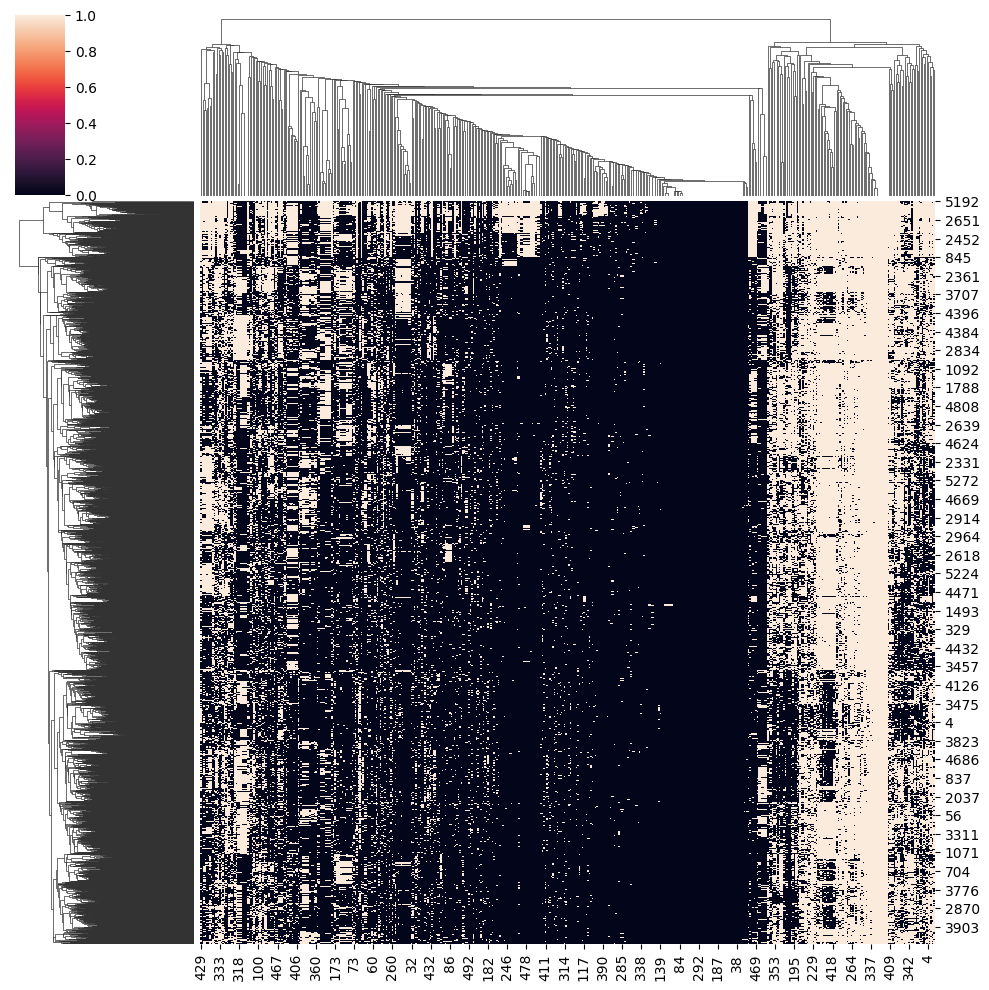

In [42]:
import seaborn as sn

sn.clustermap(C > 0)

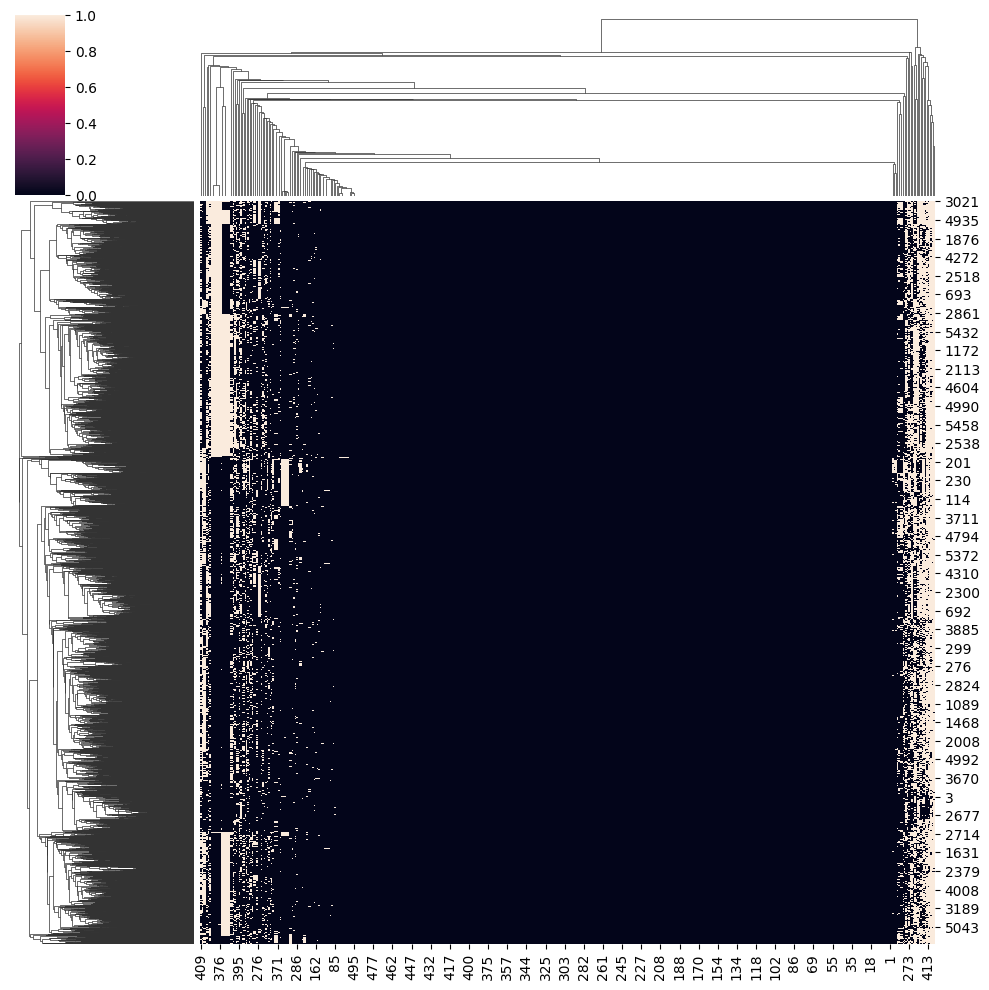

In [58]:
sn.clustermap(D > 0)

In [145]:
con_id = np.random.choice(np.arange(len(consumers)), size = 10 )
L_id = np.sum(D,axis = 0)  != 0
L_id.shape

(499,)

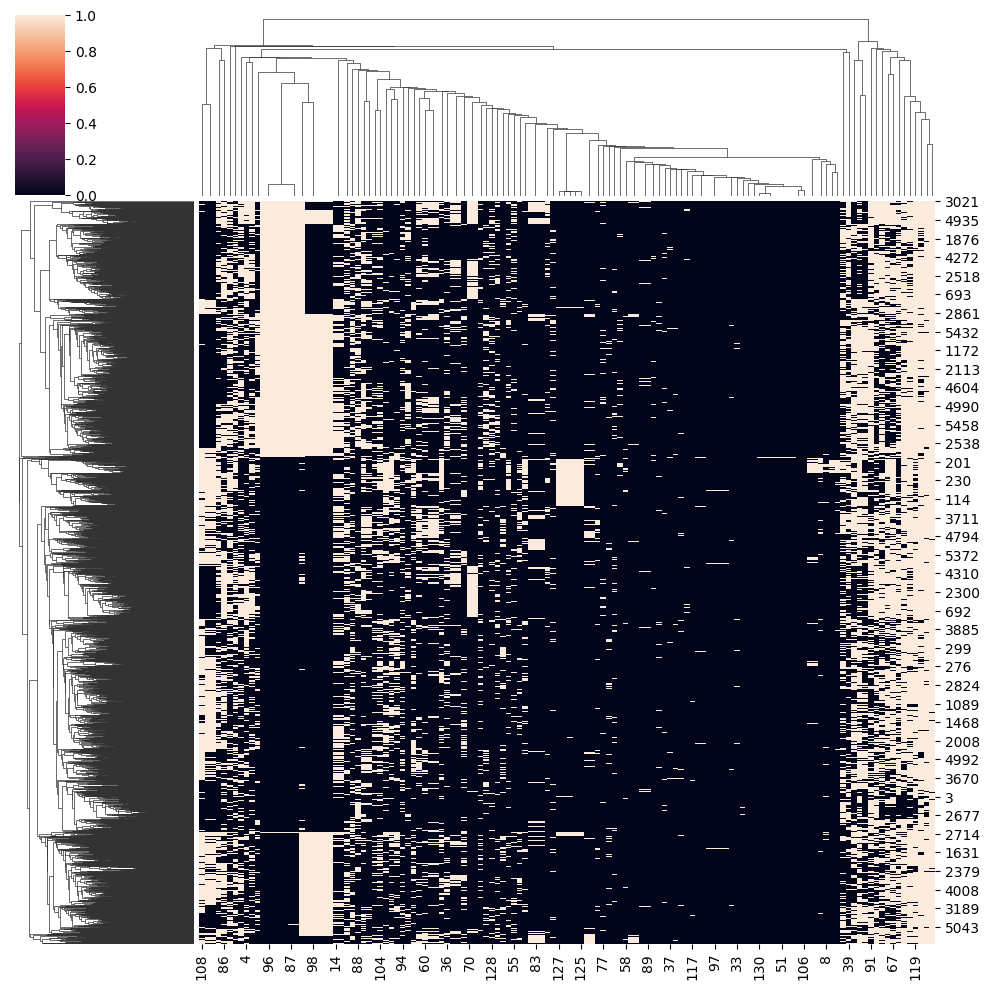

In [144]:
sn.clustermap(D[:,:][:,L_id] > 0)

In [146]:
D[:,:][:,L_id] > 0

array([[ True, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])